# Fraud Detection For WSL

## Import libraries

In [276]:
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
%matplotlib inline

from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler, IndexToString

from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
import os
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline

import itertools

from xgboost import XGBClassifier
from sklearn.preprocessing import LabelBinarizer, StandardScaler
from sklearn_pandas import DataFrameMapper

## Load data

In [163]:
import os, pandas as pd
# Add asset from file system
df_data_1 = pd.read_csv(os.environ['DSX_PROJECT_DIR']+'/datasets/History_Transactions_v4.csv')
# only keep variables we will use later
df_data_1 = df_data_1[['Dollar_Amount', 
                       'Transaction_Type',
                       'Store_Type', 
                       'Cardholder_Region', 
                       'Country',
                       'Fraudulent',
                       'Last3hourTransactions',
                       'Hours_Since_Last_Transaction'
                      ]]
df_data_1.head()

,Dollar_Amount,Transaction_Type,Store_Type,Cardholder_Region,Country,Fraudulent,Last3hourTransactions,Hours_Since_Last_Transaction
0,188.56,swiped,ATM Withdrawal,E,USA,F,4,21
1,160.54,keyed,Grocery,NE,Australia,F,3,21
2,153.24,swiped,Retail - Pharmacy,SW,European Union,T,2,21
3,148.66,keyed,Communications - telephone and wireless,NW,USA,F,1,35
4,174.03,keyed,Spa/Beauty,SW,Asia,F,1,25


In [3]:
# check missing
df_data_1.apply(lambda x: sum(x.isnull()))

Dollar_Amount                   0
Transaction_Type                0
Store_Type                      0
Cardholder_Region               0
Country                         0
Fraudulent                      0
Last3hourTransactions           0
Hours_Since_Last_Transaction    0
dtype: int64

In [4]:
# Look at categorical variables
var = ['Fraudulent', 'Transaction_Type', 'Store_Type', 'Cardholder_Region', 'Country']
for v in var:
    print("****************************************")
    print('\nFrequency count for variable %s'%v)
    print(df_data_1[v].value_counts())

****************************************

Frequency count for variable Fraudulent
F    52132
T     2903
Name: Fraudulent, dtype: int64
****************************************

Frequency count for variable Transaction_Type
swiped    27623
keyed     27412
Name: Transaction_Type, dtype: int64
****************************************

Frequency count for variable Store_Type
Restaurant                                 4470
Professional Services                      3443
Grocery                                    3403
Gas                                        3261
Other                                      3226
Hotel                                      3206
Retail - Apparel                           2276
ATM Withdrawal                             2240
Retail - Furniture                         2232
Entertainment and Arts                     2207
Retail - Home Improvement                  2194
Retail - Drug Store                        2193
Communications - telephone and wireless    2191
Me

## Split into training and test sets

In [164]:
y = df_data_1['Fraudulent'].map(lambda l: 1 if l == 'T' else 0)
X = df_data_1.drop(['Fraudulent'], axis=1)

from sklearn.model_selection import train_test_split 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234567)

print("Number of training records: " + str(len(X_train)))
print("Training: T = : " + str(sum(y_train)))
print("Training: F = : " + str(len(X_train) - sum(y_train)))
print("Number of testing records : " + str(len(X_test)))
print("Testing: T = : " + str(sum(y_test)))
print("Testing: F = : " + str(len(X_test) - sum(y_test)))

Number of training records: 44028
Training: T = : 2304
Training: F = : 41724
Number of testing records : 11007
Testing: T = : 599
Testing: F = : 10408


## Use SMOTE to rebalance the training set

In [165]:
from imblearn.over_sampling import SMOTENC

In [189]:
X_train_dummy = pd.get_dummies(X_train)
#sm = SMOTE(random_state=2662761, sampling_strategy = 'auto', k_neighbors = 5)
sm = SMOTENC(random_state=42, categorical_features=list(range(3, 44)))
X_train_res, y_train_res = sm.fit_sample(X_train_dummy, y_train)

print('Fraud/Non-Fraud Ratio Before SMOTE: ' + str(y_train.sum()/len(y_train)))
print('Fraud/Non-Fraud Ratio After SMOTE: ' + str(y_train_res.sum()/len(y_train_res)))

print("Fraud in Training after SMOTE = T: " + str(sum(y_train_res)))
print("Fraud in Training after SMOTE = F: " + str(len(y_train_res) - sum(y_train_res)))
print("\n************Test Set************\n")
print("Number of testing records : " + str(len(X_test)))
print("Training: T = : " + str(sum(y_test)))
print("Training: F = :" + str(len(y_test) - sum(y_test)))

Fraud/Non-Fraud Ratio Before SMOTE: 0.05233033524121014
Fraud/Non-Fraud Ratio After SMOTE: 0.5
Fraud in Training after SMOTE = T: 41724
Fraud in Training after SMOTE = F: 41724

************Test Set************

Number of testing records : 11007
Training: T = : 599
Training: F = :10408


In [190]:
# in order to build pipeline, we need to reverse the matrix returned by SMOTE to df
X_train_df = pd.DataFrame(X_train_res)
X_train_df.columns = pd.get_dummies(X_train).columns.tolist()

X_train_df['Transaction_Type'] = X_train_df[['Transaction_Type_keyed', 'Transaction_Type_swiped']].idxmax(axis=1).map(lambda l: l.replace('Transaction_Type_', ''))
X_train_df['Store_Type'] = X_train_df[['Store_Type_ATM Withdrawal',
       'Store_Type_Communications - telephone and wireless',
       'Store_Type_Education and Instruction',
       'Store_Type_Entertainment and Arts', 'Store_Type_Gas',
       'Store_Type_Grocery', 'Store_Type_Hotel', 'Store_Type_Medical',
       'Store_Type_Other', 'Store_Type_Professional Services',
       'Store_Type_Restaurant', 'Store_Type_Retail - Apparel',
       'Store_Type_Retail - Books', 'Store_Type_Retail - Convenience Store',
       'Store_Type_Retail - Drug Store', 'Store_Type_Retail - Floral',
       'Store_Type_Retail - Furniture', 'Store_Type_Retail - Home Electronics',
       'Store_Type_Retail - Home Improvement',
       'Store_Type_Retail - Jewelry and Watches',
       'Store_Type_Retail - Office and School Supplies',
       'Store_Type_Retail - Pharmacy', 'Store_Type_Retail - Toys',
       'Store_Type_Retail - Weapons', 'Store_Type_Spa/Beauty',
       'Store_Type_Utilities', 'Store_Type_e-Retail']].idxmax(axis=1).map(lambda l: l.replace('Store_Type_', ''))

X_train_df['Country'] = X_train_df[['Country_Asia', 'Country_Australia',
       'Country_European Union', 'Country_USA']].idxmax(axis=1).map(lambda l: l.replace('Country_', ''))

X_train_df['Cardholder_Region'] = X_train_df[['Cardholder_Region_E',
       'Cardholder_Region_N', 'Cardholder_Region_NE', 'Cardholder_Region_NW',
       'Cardholder_Region_S', 'Cardholder_Region_SE', 'Cardholder_Region_SW',
       'Cardholder_Region_W']].idxmax(axis=1).map(lambda l: l.replace('Cardholder_Region_', ''))

X_train_df = X_train_df.drop(['Transaction_Type_keyed', 'Transaction_Type_swiped', 'Store_Type_ATM Withdrawal',
       'Store_Type_Communications - telephone and wireless',
       'Store_Type_Education and Instruction',
       'Store_Type_Entertainment and Arts', 'Store_Type_Gas',
       'Store_Type_Grocery', 'Store_Type_Hotel', 'Store_Type_Medical',
       'Store_Type_Other', 'Store_Type_Professional Services',
       'Store_Type_Restaurant', 'Store_Type_Retail - Apparel',
       'Store_Type_Retail - Books', 'Store_Type_Retail - Convenience Store',
       'Store_Type_Retail - Drug Store', 'Store_Type_Retail - Floral',
       'Store_Type_Retail - Furniture', 'Store_Type_Retail - Home Electronics',
       'Store_Type_Retail - Home Improvement',
       'Store_Type_Retail - Jewelry and Watches',
       'Store_Type_Retail - Office and School Supplies',
       'Store_Type_Retail - Pharmacy', 'Store_Type_Retail - Toys',
       'Store_Type_Retail - Weapons', 'Store_Type_Spa/Beauty',
       'Store_Type_Utilities', 'Store_Type_e-Retail', 'Country_Asia', 'Country_Australia',
       'Country_European Union', 'Country_USA', 'Cardholder_Region_E',
       'Cardholder_Region_N', 'Cardholder_Region_NE', 'Cardholder_Region_NW',
       'Cardholder_Region_S', 'Cardholder_Region_SE', 'Cardholder_Region_SW',
       'Cardholder_Region_W'], 1)

## Building Pipeline

In [181]:
numCols = ["Dollar_Amount", "Last3hourTransactions", "Hours_Since_Last_Transaction"]
catCols = ["Transaction_Type", "Store_Type", "Cardholder_Region", "Country"]
label_Col = ['Fraudulent']

In [195]:
# Feature Engineering
SI1 = StringIndexer(inputCol='Transaction_Type', outputCol='Transaction_Type'+'Index')

OH1 = OneHotEncoder(inputCol='Transaction_Type' + 'Index', outputCol='Transaction_Type' + 'classVec')

SI2 = StringIndexer(inputCol='Store_Type', outputCol='Store_Type'+'Index')

OH2 = OneHotEncoder(inputCol='Store_Type' + 'Index', outputCol='Store_Type' + 'classVec')

SI3 = StringIndexer(inputCol='Cardholder_Region', outputCol='Cardholder_Region'+'Index')

OH3 = OneHotEncoder(inputCol='Cardholder_Region' + 'Index', outputCol='Cardholder_Region' + 'classVec')

SI4 = StringIndexer(inputCol='Country', outputCol='Country'+'Index')

OH4 = OneHotEncoder(inputCol='Country' + 'Index', outputCol='Country' + 'classVec')

assemblerInputs = list(map(lambda c: c + "classVec", catCols)) + numCols

assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")

rf = RandomForestClassifier()

ppl_build = Pipeline(stages=[SI1, OH1, SI2, OH2, SI3, OH3, SI4, OH4, assembler, rf])

In [194]:
# change to spark dataframe
X_train_df["label"] = y_train_res
train_data = spark.createDataFrame(X_train_df)
X_test['label'] = y_test
test_data = spark.createDataFrame(X_test)

In [196]:
#fit the pipeline
ppl_fit = ppl_build.fit(train_data)

## Feature Importance

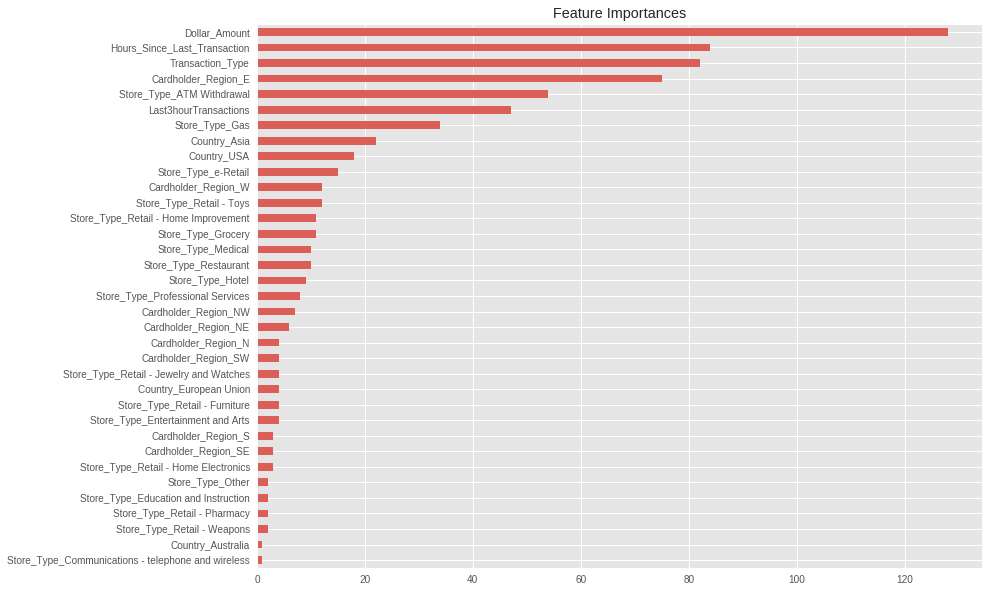

In [275]:
mapper1 = DataFrameMapper(
    [(['Dollar_Amount'], None),
     (['Last3hourTransactions'], None),
     (['Hours_Since_Last_Transaction'], None),
     ('Transaction_Type', LabelBinarizer()), # for binary, only one variable generated
     ('Store_Type', LabelBinarizer()),
     ('Cardholder_Region', LabelBinarizer()),
     ('Country', LabelBinarizer())
     ])

X_train_res_maptrsfm = mapper1.fit_transform(X_train_df)
X_test_maptrsfm = mapper1.fit_transform(X_test)

xgb_model_spss = XGBClassifier()

xgb_model_spss.fit(X_train_res_maptrsfm, y_train_res)

fig, axs = plt.subplots(nrows= 1, figsize=(13, 10))
feat_imp = pd.Series(xgb_model_spss._Booster.get_fscore()).sort_values()
X_train_dummy_names  =  mapper1.fit(X_train_df).transformed_names_

x=[]
for i in range(0, len(X_train_dummy_names)):
    x.append( "f"+ str(i))

feat_imp_reindex = feat_imp.rename(lambda y: dict(zip(x, X_train_dummy_names))[y])
feat_imp_reindex.plot(kind='barh', title='Feature Importances')

## Model Evaluation

*****Classification Report*****
              precision    recall  f1-score   support

           0       0.95      0.96      0.96     10408
           1       0.13      0.10      0.12       599

    accuracy                           0.92     11007
   macro avg       0.54      0.53      0.54     11007
weighted avg       0.90      0.92      0.91     11007

ROC: 0.631174138552725
Confusion matrix, without normalization
[[10014   394]
 [  538    61]]


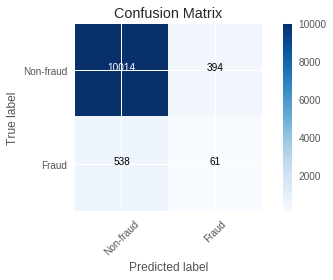

In [180]:
predictions = ppl_fit.transform(test_data)
pred_pd = predictions.toPandas()
roc = roc_auc_score(pred_pd['label'], pred_pd['probability'].map(lambda l: l[1]))
cnf_matrix = confusion_matrix(pred_pd['label'], pred_pd['probability'].map(lambda l: l[1]).round())
print("*****Classification Report*****")
print(classification_report(pred_pd['label'], pred_pd['probability'].map(lambda l: l[1]).round()))
print("ROC: " +  str(roc))

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

plot_confusion_matrix(cnf_matrix, ["Non-fraud", "Fraud"],
                      title='Confusion Matrix')

## Save Model

In [55]:
from dsx_ml.ml import save

In [158]:
model_name = "Fraud_spark_model_updated"
save(name = model_name,
     model = ppl_fit,
     algorithm_type = 'Classification',
     test_data = test_data)

{'path': '/user-home/1063/DSX_Projects/Fraud Transactions/models/Fraud_spark_model_updated/1',
 'scoring_endpoint': 'https://dsxl-api/v3/project/score/Python35/spark-2.2/Fraud%20Transactions/Fraud_spark_model_updated/1'}